# Ligand-based validation

Check if we can retrieve on-/off-targets for a selected ligand (as reported by Karaman et al.) solely based on the structurally most similar kinases to respective main target of that ligand.

1. Select ligands to investigate: Erlotinib and Imatinib (target ligands).
2. Get target of Erlotinib and Imatinib: EGFR and ABL1 (target kinases).
3. Find top20 and top30 similar kinases to target kinase.
4. Save these top kinases in KinMap format for visualization using the KinMap website.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from kissim.comparison import FingerprintDistanceGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data/"
RESULTS = HERE / "../../results/"

## Load kinase names from KinMap

In [4]:
kinase_names_mapping = pd.read_csv(
    "https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.csv"
)
kinase_names_mapping.head()

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519
1,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,NaN,Q07912
2,ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037
3,ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705
4,ADCK4,ADCK4,ADCK4,Uncharacterized aarF domain-containing protein...,Atypical,ABC1,ABC1-A,Q96D53


## Load kinase matrix

In [5]:
fingerprint_distance_generator_path = RESULTS / "fingerprint_distances_111.csv"
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(
    fingerprint_distance_generator_path
)

In [6]:
kinase_matrix = fingerprint_distance_generator.kinase_distance_matrix("minimum")

In [7]:
def update_kinase_name(kinase_name, kinase_names_mapping):
    kinase_name = kinase_name.replace("-", "_")
    if kinase_names_mapping["xName"].isin([kinase_name]).any():
        return kinase_name
    else:
        kinase_name_kinmap = kinase_names_mapping[
            (kinase_names_mapping["Manning\xa0Name"] == kinase_name)
            | (kinase_names_mapping["HGNC\xa0Name"] == kinase_name)
        ]
        if len(kinase_name_kinmap) == 0:
            print(f"Not in KinMap: {kinase_name}")
            return "unknown"
        elif len(kinase_name_kinmap) == 1:
            return kinase_name_kinmap.squeeze()["xName"]
        else:
            print(f"Ambiguous kinase name: {kinase_name}")
            return "unknown"

In [8]:
kinase_matrix.index = [
    update_kinase_name(kinase_name, kinase_names_mapping) for kinase_name in kinase_matrix.index
]

Not in KinMap: PI4K2A
Not in KinMap: PI4K2B
Not in KinMap: PI4KB
Not in KinMap: PIK3C3
Not in KinMap: p110a
Not in KinMap: p110d
Not in KinMap: p110g


In [9]:
kinase_matrix.columns = [
    update_kinase_name(kinase_name, kinase_names_mapping) for kinase_name in kinase_matrix.columns
]

Not in KinMap: PI4K2A
Not in KinMap: PI4K2B
Not in KinMap: PI4KB
Not in KinMap: PIK3C3
Not in KinMap: p110a
Not in KinMap: p110d
Not in KinMap: p110g


In [10]:
kinase_matrix.shape

(292, 292)

In [11]:
kinase_matrix = kinase_matrix.drop("unknown", axis=0).drop("unknown", axis=1)
kinase_matrix.shape

(285, 285)

## KinMap functions

### Set KinMap size for `kissim` kinase data

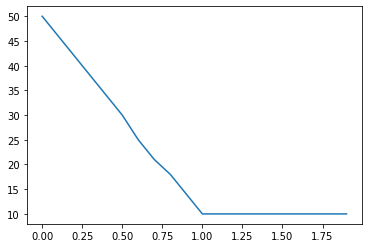

In [12]:
def kinmap_size(x):
    if x > 1:
        return 10
    else:
        return int(10 + (1 - x) * 40)


dummy_distances = np.arange(0, 2, 0.1)
plt.plot(dummy_distances, [kinmap_size(i) for i in dummy_distances]);

### Get KinMap data

- All `kissim` kinases with available distances to target kinase (plot as grey pentagon with fixed size)
- Top N `kissim` kinases (plot as blue pentagon; size depending on distance)
- Profiling data (plot as cyan circles; size depending on bioactivity)
- Merge the 3 datasets and sort by shape size (so that KinMap does not hiding small stuff behind big stuff)

In [13]:
def kissim_kinases_all(kinase_matrix, target_kinase):

    all_kinases = kinase_matrix[target_kinase].dropna().index.to_list()
    all_kinases = pd.DataFrame(all_kinases, columns=["xName"])
    all_kinases["size"] = 50
    all_kinases["shape"] = "pentagon"
    all_kinases["fill"] = "Silver"
    all_kinases["stroke"] = "LightGrey"

    return all_kinases

In [14]:
def kissim_kinases_top_n(kinase_matrix, target_kinase, top_n):

    top_kinases = kinase_matrix[target_kinase].dropna().sort_values(ascending=True)[:top_n]
    top_kinases.name = "size"
    top_kinases.index.name = "xName"
    top_kinases = top_kinases.reset_index()
    top_kinases["size"] = top_kinases["size"].apply(kinmap_size)
    top_kinases["shape"] = "pentagon"
    top_kinases["fill"] = "RoyalBlue"
    top_kinases["stroke"] = "LightGrey"

    return top_kinases

In [15]:
def profiling(target_kinase, target_ligand):
    """
    Read profiling data that has been downloaded from KinMap.
    - Go to http://www.kinhub.org/kinmap/index.html
    - Data Source: Profiling, Data type: Karaman et al., 2008
    - Choose target ligand & Add source
    - Change Fill: Cyan
    - Size/Max: 35
    """

    return pd.read_csv(DATA / f"external/profiling/KinMap/kinmap_{target_kinase}_{target_ligand}_karaman.csv")

In [16]:
def kinmap_df(kinase_matrix, target_kinase, top_n, target_ligand, output_path=None):

    all_kinases = kissim_kinases_all(kinase_matrix, target_kinase)
    top_kinases = kissim_kinases_top_n(kinase_matrix, target_kinase, top_n)
    profiled_kinases = profiling(target_kinase, target_ligand)

    kinmap = pd.concat([all_kinases, top_kinases, profiled_kinases])
    kinmap = kinmap.sort_values("size", ascending=False)

    if output_path is not None:
        kinmap.to_csv(
            Path(output_path) / f"kinmap_{target_kinase}_{target_ligand}_kissim_top{top_n}.csv",
            index=False,
        )

    return kinmap

In [17]:
def main(kinase_matrix, target_kinase, target_ligand, output_path):

    # Generate KinMap file format
    kinmap_df(kinase_matrix, target_kinase, 20, target_ligand, output_path)
    kinmap_df(kinase_matrix, target_kinase, 30, target_ligand, output_path)
    kinmap_df(kinase_matrix, target_kinase, 50, target_ligand, output_path)

## Generate KinMap upload files

### Off-targets for ABL1 (Imatinib)

In [18]:
target_kinase = "ABL1"
target_ligand = "imatinib"

main(kinase_matrix, target_kinase, target_ligand, RESULTS)

### Off-targets for EGFR (Erlotinib)

In [19]:
target_kinase = "EGFR"
target_ligand = "erlotinib"

main(kinase_matrix, target_kinase, target_ligand, RESULTS)

### Off-targets for EGFR (Gefitinib)

In [20]:
target_kinase = "EGFR"
target_ligand = "gefitinib"

main(kinase_matrix, target_kinase, target_ligand, RESULTS)

## Generate KinMap tree

__Manually__ upload CSV file to KinMap and download as SVG. Convert to PNG using the `results/kinmap/svg_to_png.sh` script.